RandomForest Accuracy: 0.6666666666666666
DecisionTree Accuracy: 0.21428571428571427
NaiveBayes Accuracy: 1.0


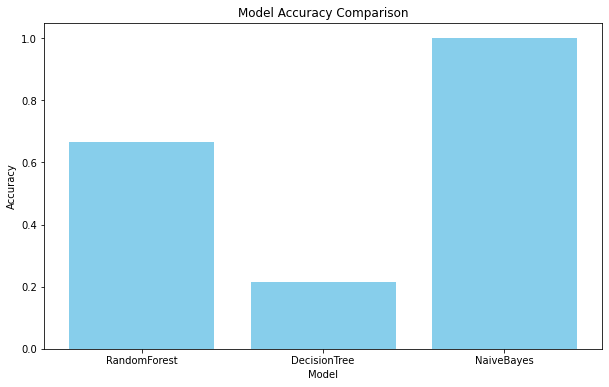

Predicted Disease using RandomForest: hepatitis A
Predicted Disease using DecisionTree: (vertigo) Paroymsal  Positional Vertigo
Predicted Disease using NaiveBayes: Chicken pox

Predicted Disease using RandomForest: GERD
Predicted Disease using DecisionTree: (vertigo) Paroymsal  Positional Vertigo
Predicted Disease using NaiveBayes: GERD



In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.sql import Row

# Initialize Spark session
spark = SparkSession.builder.appName("DiseasePredictionComparison").getOrCreate()

# Load the datasets

train_data = spark.read.format("csv").option("header", "true").load("/FileStore/tables/Train-3.csv")
test_data = spark.read.format("csv").option("header", "true").load("/FileStore/tables/Test-2.csv")

# Convert symptom columns from string to numeric
for column in train_data.columns[:-1]:  # Exclude the last column (Disease/Prognosis)
    train_data = train_data.withColumn(column, col(column).cast('integer'))
    test_data = test_data.withColumn(column, col(column).cast('integer'))

# Data preprocessing
feature_columns = train_data.columns[:-1]  # all columns except the last one
labelIndexer = StringIndexer(inputCol="prognosis", outputCol="indexedLabel").fit(train_data)

# Vector assembler to combine feature columns into a single features column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Initialize classifiers
classifiers = {
    "RandomForest": RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=10),
    "DecisionTree": DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="features"),
    "NaiveBayes": NaiveBayes(labelCol="indexedLabel", featuresCol="features", modelType="multinomial")
}

# Train models and evaluate
accuracies = {}
for name, classifier in classifiers.items():
    # Create and train the pipeline
    pipeline = Pipeline(stages=[labelIndexer, assembler, classifier])
    model = pipeline.fit(train_data)
    
    # Make predictions
    predictions = model.transform(test_data)
    
    # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    accuracies[name] = accuracy
    print(f"{name} Accuracy: {accuracy}")

# Visualization of accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

# Example symptom inputs

ex_List = [["mild_fever", "headache"], ["cough", "chest_pain","stomach_pain","vomiting"] ]

# Function to convert symptom strings to binary values
def symptoms_to_binary(symptoms, feature_columns):
    binary_symptoms = [1 if feature in symptoms else 0 for feature in feature_columns]
    return binary_symptoms


# Function to predict disease using any model
def predict_disease_from_symptoms(symptom_strings, model):
    binary_symptoms = symptoms_to_binary(symptom_strings, feature_columns)
    row = Row(*feature_columns)(*binary_symptoms)
    symptoms_df = spark.createDataFrame([row])
    prediction = model.transform(symptoms_df)
    predicted_index = prediction.select("prediction").first()[0]
    predicted_disease = labelIndexer.labels[int(predicted_index)]
    return predicted_disease

# Comparing different models to make a prediction
rf_model = Pipeline(stages=[labelIndexer, assembler, classifiers["RandomForest"]]).fit(train_data)
dt_model = Pipeline(stages=[labelIndexer, assembler, classifiers["DecisionTree"]]).fit(train_data)
nb_model = Pipeline(stages=[labelIndexer, assembler, classifiers["NaiveBayes"]]).fit(train_data)
md_List = [rf_model,dt_model,nb_model]
modelList =["RandomForest","DecisionTree","NaiveBayes"]
for j in ex_List:

    for i in range(len(modelList)):
        predicted_disease = predict_disease_from_symptoms(j, md_List[i])
        print(f"Predicted Disease using {modelList[i]}: {predicted_disease}")
        

    print("")
